# Inferring an Approval Rating with Bernoulli Sampling

This notebook illustrates a simple model for estimating an approval rating (a population proportion) using a **Bernoulli** random variable model, simulated survey responses, and two kinds of confidence intervals:

- **Exact (Binomial) confidence interval** (via an exact binomial inversion / Clopper–Pearson style interval)
- **Central Limit Theorem (Normal approximation) confidence interval** (Wald interval)

> **Key idea:** If each respondent answers **Yes** (approve) / **No** (disapprove), we can model each response as a Bernoulli random variable  
$$
X_i \sim \Bern(p),\quad i=1,\dots,n,
$$
where $p$ is the (unknown) approval probability in the population.

We estimate $p$ with the sample proportion
$$
\phat = \frac{1}{n}\sum_{i=1}^n X_i.
$$


In [4]:
# Initialization / imports
import numpy as np
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import math

# Reproducibility
rng = np.random.default_rng(20251222)

# Paul Tol-inspired palette (high-contrast, colorblind-friendly)
TOL = {
    "blue":   "#4477AA",
    "cyan":   "#66CCEE",
    "green":  "#228833",
    "yellow": "#CCBB44",
    "red":    "#EE6677",
    "purple": "#AA3377",
    "grey":   "#BBBBBB",
    "black":  "#000000",
}

# Plot defaults
plt.rcParams.update({
    "figure.figsize": (7.5, 4.2),
    "axes.grid": True,
    "grid.alpha": 0.25,
    "axes.spines.top": False,
    "axes.spines.right": False,
})


In [5]:
# Inject LaTeX macros into MathJax so later markdown cells can use \Bern, \Bin, \phat, etc.
from IPython.display import display, Markdown

display(Markdown(r'''
$$
\newcommand{\Bern}{\mathrm{Bern}}
\newcommand{\Bin}{\mathrm{Bin}}
\newcommand{\E}{\mathbb{E}}
\newcommand{\Var}{\mathrm{Var}}
\newcommand{\phat}{\widehat{p}}
\newcommand{\zalpha}{z_{1-\alpha/2}}
$$
'''))



$$
\newcommand{\Bern}{\mathrm{Bern}}
\newcommand{\Bin}{\mathrm{Bin}}
\newcommand{\E}{\mathbb{E}}
\newcommand{\Var}{\mathrm{Var}}
\newcommand{\phat}{\widehat{p}}
\newcommand{\zalpha}{z_{1-\alpha/2}}
$$


## Parameters

You can change these and re-run to generate a new simulated survey.

- \(n\): sample size (number of respondents)
- \(p\): the *true* (unknown) approval probability (used here only to simulate data)
- \(1-\alpha\): confidence level (e.g., 0.95)


In [6]:
# Parameters (edit as desired)
n = 500          # sample size
p_true = 0.54    # "true" approval probability (for simulation)
alpha = 0.05     # 95% CI

# Simulate survey responses: 1 = Yes/Approve, 0 = No/Disapprove
x = rng.binomial(n=1, p=p_true, size=n)
k = int(x.sum())          # number of Yes responses
phat = k / n              # sample proportion

n, k, phat


(500, 270, 0.54)

## Visualizing the responses

A bar chart of the counts of **Yes** and **No** responses.


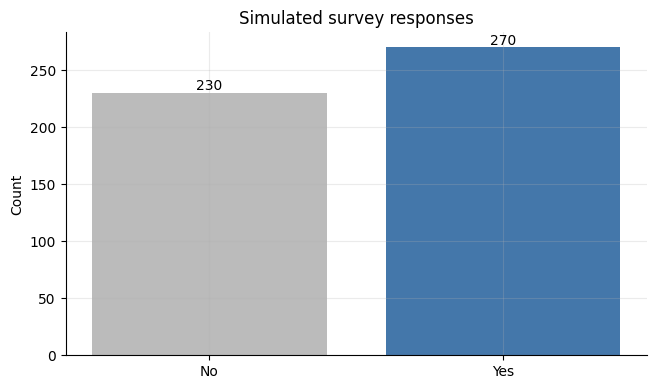

In [7]:
counts = np.array([n - k, k])
labels = ["No", "Yes"]

fig, ax = plt.subplots()
bars = ax.bar(labels, counts, color=[TOL["grey"], TOL["blue"]])
ax.set_title("Simulated survey responses")
ax.set_ylabel("Count")
for b in bars:
    ax.text(b.get_x() + b.get_width()/2, b.get_height(), f"{int(b.get_height())}",
            ha="center", va="bottom")
plt.show()


## Bernoulli / Binomial model

If each response is Bernoulli,
\[
X_i \sim \Bern(p),\quad i=1,\dots,n,
\]
then the total number of Yes responses
\[
K=\sum_{i=1}^n X_i
\]
has a binomial distribution:
\[
K \sim \Bin(n,p).
\]

We estimate \(p\) with \(\phat = K/n\).

### Standard error (CLT / Normal approximation)

By the Central Limit Theorem, for large \(n\), the sampling distribution of \(\phat\) is approximately normal:
\[
\phat \approx \mathcal{N}\!\left(p,\; \frac{p(1-p)}{n}\right).
\]

Replacing \(p\) with \(\phat\) gives the estimated standard error:
\[
\widehat{\mathrm{SE}}(\phat)=\sqrt{\frac{\phat(1-\phat)}{n}}.
\]


## Confidence intervals

We compute two intervals:

1. **Exact (Binomial) interval** via `scipy.stats.binomtest(...).proportion_ci(...)`
2. **CLT (Normal approximation) interval** (Wald):  
   \[
   \phat \pm \zalpha\sqrt{\frac{\phat(1-\phat)}{n}}.
   \]

> The CLT/Wald interval is simple, but it can behave poorly for small samples or when \(\phat\) is very close to 0 or 1.


In [8]:
# 1) Exact binomial confidence interval (Clopper–Pearson-style)
bt = stats.binomtest(k, n=n, p=0.5)  # p is irrelevant for the CI call; scipy uses k,n
ci_exact = bt.proportion_ci(confidence_level=1-alpha, method="exact")

# 2) CLT / Wald interval
z = stats.norm.ppf(1 - alpha/2)
se_hat = math.sqrt(phat * (1 - phat) / n)
ci_clt = (max(0.0, phat - z * se_hat), min(1.0, phat + z * se_hat))

(ci_exact.low, ci_exact.high), ci_clt, z, se_hat


((0.495187538535803, 0.5843368684372415),
 (np.float64(0.49631434168836597), np.float64(0.5836856583116341)),
 np.float64(1.959963984540054),
 0.022289010745208053)

## Report the estimate and intervals

In [9]:
def fmt_pct(x):
    return f"{100*x:.1f}%"

print(f"Sample size n = {n}")
print(f"Yes count k = {k}")
print(f"Point estimate phat = {phat:.4f} ({fmt_pct(phat)})")
print()
print(f"{int((1-alpha)*100)}% exact (binomial) CI: [{ci_exact.low:.4f}, {ci_exact.high:.4f}]  "
      f"= [{fmt_pct(ci_exact.low)}, {fmt_pct(ci_exact.high)}]")
print(f"{int((1-alpha)*100)}% CLT (Wald) CI:       [{ci_clt[0]:.4f}, {ci_clt[1]:.4f}]  "
      f"= [{fmt_pct(ci_clt[0])}, {fmt_pct(ci_clt[1])}]")


Sample size n = 500
Yes count k = 270
Point estimate phat = 0.5400 (54.0%)

95% exact (binomial) CI: [0.4952, 0.5843]  = [49.5%, 58.4%]
95% CLT (Wald) CI:       [0.4963, 0.5837]  = [49.6%, 58.4%]


## How do the intervals compare?

- The **exact** interval is derived from the binomial model with no normal approximation.
- The **CLT/Wald** interval uses a normal approximation and plugs in \(\phat\) for \(p\).

For moderate to large \(n\) and proportions not near 0 or 1, they are often similar.


In [10]:
# Optional: Monte Carlo check of approximate coverage (quick demo).
# Increase reps for a more stable estimate.
reps = 2000
p0 = p_true

def ci_exact_for_k(k_):
    bt_ = stats.binomtest(int(k_), n=n, p=0.5)
    ci_ = bt_.proportion_ci(confidence_level=1-alpha, method="exact")
    return (ci_.low, ci_.high)

def ci_clt_for_k(k_):
    ph_ = k_ / n
    se_ = math.sqrt(ph_ * (1 - ph_) / n) if ph_ * (1 - ph_) > 0 else 0.0
    lo = max(0.0, ph_ - z * se_)
    hi = min(1.0, ph_ + z * se_)
    return (lo, hi)

ks = rng.binomial(n=n, p=p0, size=reps)

cover_exact = np.mean([(ci_exact_for_k(k_)[0] <= p0 <= ci_exact_for_k(k_)[1]) for k_ in ks])
cover_clt   = np.mean([(ci_clt_for_k(k_)[0]   <= p0 <= ci_clt_for_k(k_)[1])   for k_ in ks])

print(f"Monte Carlo estimated coverage at p={p0:.3f}, n={n}, reps={reps}:")
print(f"  Exact CI coverage ≈ {cover_exact:.3f}")
print(f"  CLT/Wald coverage ≈ {cover_clt:.3f}")


Monte Carlo estimated coverage at p=0.540, n=500, reps=2000:
  Exact CI coverage ≈ 0.958
  CLT/Wald coverage ≈ 0.944


## Interpreting a confidence interval

A \(95\%\) confidence interval procedure has the property that **in repeated sampling**, about \(95\%\) of the intervals produced will contain the true \(p\).

It does **not** mean: “there is a 95% probability that \(p\) lies in this particular computed interval.”


## Extensions (ideas)

- Explore how the CI width depends on \(n\) (sample size) and \(\phat\).
- Compare additional intervals (Wilson, Agresti–Coull, Jeffreys) and their coverage.
- Discuss survey design: nonresponse, weighting, likely-voter screens, and “margin of error.”
